In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder


/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.18.0
TensorFlow Decision Forests v1.11.0


# First look

In [3]:
data = pd.read_csv('data/train.csv')
data.info()
testing = pd.read_csv('data/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0.1                    5352 non-null   int64  
 1   Unnamed: 0                      5352 non-null   int64  
 2   id                              5352 non-null   int64  
 3   name                            5352 non-null   object 
 4   neighborhood_overview           3476 non-null   object 
 5   host_id                         5352 non-null   int64  
 6   host_name                       5352 non-null   object 
 7   host_response_time              4263 non-null   object 
 8   host_response_rate              4263 non-null   object 
 9   host_acceptance_rate            4620 non-null   object 
 10  host_is_superhost               5315 non-null   object 
 11  host_listings_count             5352 non-null   int64  
 12  host_total_listings_count       53

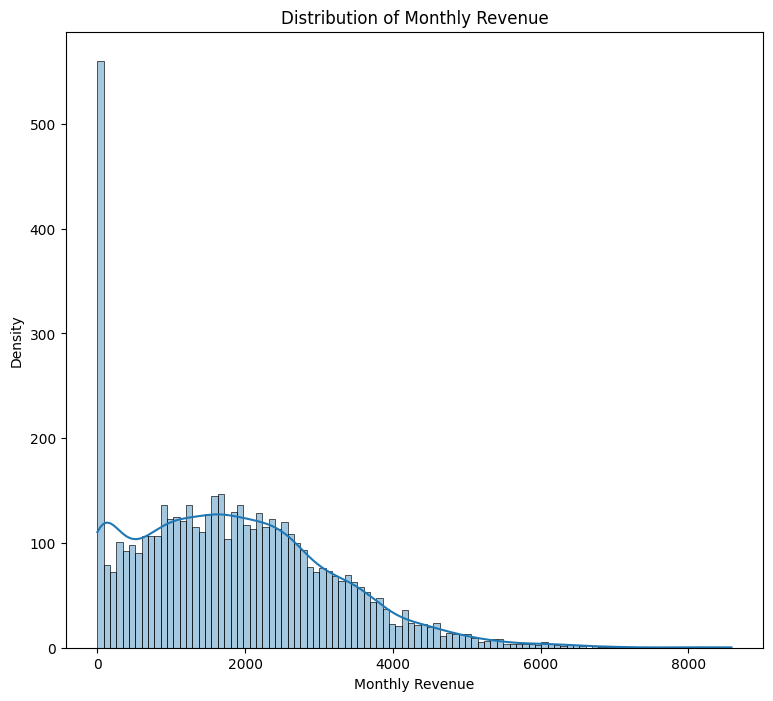

In [4]:
plt.figure(figsize=(9, 8))
sns.histplot(data['monthly_revenue'], bins=100, kde=True, alpha=0.4) 
plt.title("Distribution of Monthly Revenue")
plt.xlabel("Monthly Revenue")
plt.ylabel("Density")
plt.show()

# Handling Missing Values & Cleaning

In [5]:
def na_access(data):
    for col in data.columns: 
        if data[col].isna().sum() > 0: 
            print(f"{col}: ", data[col].isna().sum())

In [6]:
pd.set_option('display.max_colwidth', None)
na_access(data)
print("--------------------")
na_access(testing)



neighborhood_overview:  1876
host_response_time:  1089
host_response_rate:  1089
host_acceptance_rate:  732
host_is_superhost:  37
neighbourhood:  1876
beds:  36
price:  665
review_scores_rating:  900
review_scores_accuracy:  900
review_scores_cleanliness:  900
review_scores_checkin:  901
review_scores_communication:  900
review_scores_location:  901
review_scores_value:  901
reviews_per_month:  906
--------------------
neighborhood_overview:  455
host_response_time:  274
host_response_rate:  274
host_acceptance_rate:  195
host_is_superhost:  10
neighbourhood:  455
bathrooms:  1339
bedrooms:  1338
beds:  9
price:  175
review_scores_rating:  232
review_scores_accuracy:  232
review_scores_cleanliness:  232
review_scores_checkin:  232
review_scores_communication:  232
review_scores_location:  232
review_scores_value:  232
reviews_per_month:  233


In [7]:
# Helper for main clean function: 
def extract_bedrooms(row):
    # Check if it's a studio
    if "studio" in row['name'].lower():
        return 0  # Studio has 0 bedrooms
    # Use regex to extract bedrooms
    match = re.search(r'(\d+)\s+bedrooms?', row['name'].lower())
    if match:
        return int(match.group(1))
    # Fallback: 
    return row['beds']

def extract_bathrooms(row):
    bathroom_string = row['name'].split('·')[-1].strip()
    if "half" in bathroom_string.lower():
        return 0.5
    else:
        return bathroom_string[0]    

In [8]:
def clean(data): 
    if 'Unnamed: 0' in data.columns:
        data = data.drop(columns=['Unnamed: 0', 'id'])
        
    data['bathrooms'] = data.apply(extract_bathrooms, axis=1)
    
    data['bedrooms'] = data.apply(extract_bedrooms, axis=1)


    data['bathrooms'] = pd.to_numeric(data['bathrooms'], errors='coerce')  # Convert to numeric
    data['bedrooms'] = pd.to_numeric(data['bedrooms'], errors='coerce')  # Convert to numeric
    data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)  # Remove $ and commas, convert to float
    data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype(float)  # Remove % and convert to float
    data['host_acceptance_rate'] = data['host_acceptance_rate'].str.rstrip('%').astype(float)  # Remove % and convert to float


    # Convert columns to boolean
    boolean_columns = ['host_is_superhost', 'instant_bookable']
    data[boolean_columns] = data[boolean_columns].apply(lambda x: x.map({'t': 1, 'f': 0})).astype('float')


    # Convert cols to float
    if 'monthly_revenue' in data.columns:
        data['monthly_revenue'] = data['monthly_revenue'].astype('float')

    # Fix beds
    data['beds'] = data['beds'].fillna(data['bedrooms'])
    data['beds'] = data['beds'].astype('float')

    categorical_columns = [
        'host_response_time',
        'neighbourhood',
        'neighbourhood_cleansed',
        'property_type',
        'room_type'
        ]   
    data[categorical_columns] = data[categorical_columns].astype('category')
    
    data['review_scores_value'] = data['review_scores_value'].fillna(data['review_scores_value'].mean())


    
    # Handle review scores
    review_score_columns = [
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ]
    
    for column in review_score_columns:
        if column == 'review_scores_rating':
            data.loc[data['number_of_reviews'] == 0, column] = 2.5
        else:
            data.loc[data[column].isnull(), column] = data.loc[data[column].isnull(), 'review_scores_rating']
    
    data.loc[data['number_of_reviews'] == 0, 'reviews_per_month'] = 0
    
    # Handle 'host_response_time'
    if 'unknown' not in data['host_response_time'].cat.categories:
        data['host_response_time'] = data['host_response_time'].cat.add_categories(['unknown'])
    data['host_response_time'] = data['host_response_time'].fillna('unknown')
    
    # Impute missing rates
    data['host_response_rate'] = data['host_response_rate'].fillna(data['host_response_rate'].median())
    data['host_acceptance_rate'] = data['host_acceptance_rate'].fillna(data['host_acceptance_rate'].median())


    predictors = [
    'host_response_rate', 'host_acceptance_rate', 'number_of_reviews',
    'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
    ]

    target = 'host_is_superhost'
    # Handle missing values in target
    train_data = data[data[target].notnull()]
    test_data = data[data[target].isnull()]
    
    if test_data.empty:
        return data  # No missing target values to predict
    
    # Predict missing target values
    X_train = train_data[predictors]
    y_train = train_data[target]
    X_test = test_data[predictors]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(random_state=42, max_iter=500)
    model.fit(X_train_scaled, y_train)
    
    y_test_pred = model.predict(X_test_scaled)
    data.loc[test_data.index, target] = y_test_pred

    # Label encode the selected columns
    # label_encoders = {}
    # for column in ['neighbourhood_cleansed', 'property_type', 'room_type']:
    #     le = LabelEncoder()
    #     data[column] = le.fit_transform(data[column])
    #     label_encoders[column] = le  # Save the encoder for future use
    
    return data

In [9]:
# Reset
data = pd.read_csv('data/train.csv')
testing = pd.read_csv('data/test.csv')
data = clean(data) 
testing = clean(testing)



In [10]:
print("Data Types: ")
print(data.dtypes)
print("\n")
print("-----------")
na_access(data)
print("-----------")
na_access(testing)

Data Types: 
Unnamed: 0.1                         int64
name                                object
neighborhood_overview               object
host_id                              int64
host_name                           object
host_response_time                category
host_response_rate                 float64
host_acceptance_rate               float64
host_is_superhost                  float64
host_listings_count                  int64
host_total_listings_count            int64
neighbourhood                     category
neighbourhood_cleansed            category
latitude                           float64
longitude                          float64
property_type                     category
room_type                         category
accommodates                         int64
beds                               float64
amenities                           object
price                              float64
minimum_nights                       int64
maximum_nights                       int6

# Data cleanup

## review_scores_*

In [11]:
predictors = [
    'number_of_reviews',
    'number_of_reviews_ltm', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month', 'review_scores_rating'
]

target = 'review_scores_checkin'

missing_rows = data[data[target].isnull()]

# Print the rows with missing values
print("Rows with missing values in 'host_is_superhost':")
print(missing_rows[predictors])

Rows with missing values in 'host_is_superhost':
Empty DataFrame
Columns: [number_of_reviews, number_of_reviews_ltm, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month, review_scores_rating]
Index: []


In [12]:
# Define review score columns
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Replace missing values in review scores if number_of_reviews == 0
for column in review_score_columns:
    if column == 'review_scores_rating':
        # If number_of_reviews == 0, set rating to 2.5
        data.loc[data['number_of_reviews'] == 0, column] = 2.5
    else:
        # Otherwise, set the review scores to match the review_scores_rating
        data.loc[data[column].isnull(), column] = data.loc[data[column].isnull(), 'review_scores_rating']

data.loc[data['number_of_reviews'] == 0, 'reviews_per_month'] = 0



na_access(data)

neighborhood_overview:  1876
neighbourhood:  1876
price:  665


## host rates and response time

In [13]:
if 'unknown' not in data['host_response_time'].cat.categories:
    data['host_response_time'] = data['host_response_time'].cat.add_categories('unknown')
data['host_response_time'] = data['host_response_time'].fillna('unknown')


data['host_response_rate'] = data['host_response_rate'].fillna(data['host_response_rate'].median())
data['host_acceptance_rate'] = data['host_acceptance_rate'].fillna(data['host_acceptance_rate'].median())
na_access(data)

neighborhood_overview:  1876
neighbourhood:  1876
price:  665


## host_is_superhost

Since a host is a superhost is determined based on if the host is committed to providing you with outstanding hospitality, it will be filled by regresison using rates and reviews 


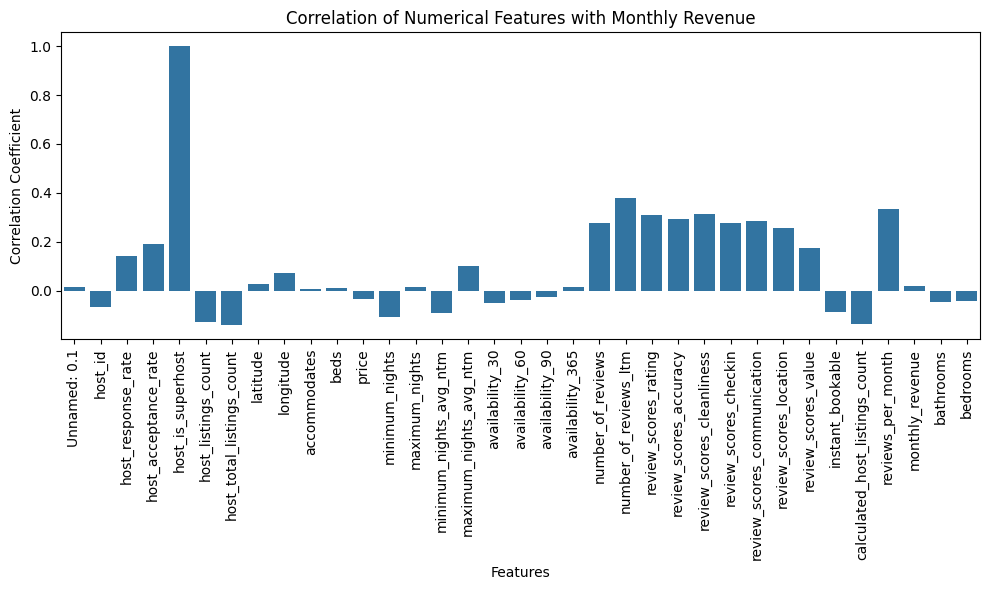

In [14]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = data[numerical_cols].corr()
revenue_correlation = correlation_matrix['host_is_superhost']
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_correlation.index, y=revenue_correlation.values)
plt.xticks(rotation=90)
plt.title("Correlation of Numerical Features with Monthly Revenue")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


In [15]:
predictors = [
    'host_response_rate', 'host_acceptance_rate', 'number_of_reviews',
    'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
]

target = 'host_is_superhost'


In [16]:
# Ensure the target column is cleaned

# Filter rows with non-missing target values
train_data = data[data[target].notnull()]
test_data = data[data[target].isnull()]

# Verify train_data is not empty
print(f"train_data shape: {train_data.shape}")
if train_data.empty:
    raise ValueError("train_data is empty after filtering. Check the target column for issues.")

# Proceed with train_test_split
X = train_data[predictors]
y = train_data[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


train_data shape: (5352, 44)


In [17]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the regression model (Logistic Regression for binary classification)
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
classification_report_output = classification_report(y_val, y_pred)

# Predict for rows with missing target values
if not test_data.empty:
    test_data_scaled = scaler.transform(test_data[predictors])
    test_data_predictions = model.predict(test_data_scaled)
    data.loc[test_data.index, target] = test_data_predictions

# Predict for rows with missing target values
if not test_data.empty:
    test_data_scaled = scaler.transform(test_data[predictors])
    test_data_predictions = model.predict(test_data_scaled)
    
    # Fill in the missing values in the original dataset
    data.loc[test_data.index, target] = test_data_predictions

# Print results
print("Accuracy on validation set:", accuracy)
print("Classification Report:\n", classification_report_output)
na_access(data)

Accuracy on validation set: 0.7226890756302521
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.84      0.78       641
         1.0       0.70      0.54      0.61       430

    accuracy                           0.72      1071
   macro avg       0.72      0.69      0.70      1071
weighted avg       0.72      0.72      0.71      1071

neighborhood_overview:  1876
neighbourhood:  1876
price:  665


In [18]:
# data['host_is_superhost'].fillna(data['host_is_superhost'].mode()[0], inplace=True)
# data['price'].fillna(data['price'].median(), inplace=True)
# review_columns = [
#     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
#     'review_scores_checkin', 'review_scores_communication', 'review_scores_location'
# ]
# for col in review_columns:
#     data[col].fillna(data[col].mean(), inplace=True)

# data['reviews_per_month'].fillna(0, inplace=True)

# na_access(data)
# print("-----------")


# TF Workflow

## Getting the predictors and response only

In [19]:
# predictors = ['property_type', 'room_type', 'neighbourhood_cleansed', 'accommodates', 
#               'bathrooms', 'bedrooms', 'beds', 'host_id', 'review_scores_value']
# response = 'monthly_revenue'

# data = data[['monthly_revenue','property_type', 'room_type', 'neighbourhood_cleansed', 'accommodates', 
#               'bathrooms', 'bedrooms', 'beds', 'host_id', 'review_scores_value']]

data = pd.read_csv('data/cleaned_data.csv')

cat_features = ['host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type']
num_features = [ 
                    'maximum_nights_avg_ntm',  'availability_365', 'number_of_reviews',
                    'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month', 'bedrooms', 'beds', 'bathrooms', 'accommodates']

data = data[['monthly_revenue',  'neighbourhood_cleansed', 'property_type', 'room_type',
             
            'maximum_nights_avg_ntm',  'number_of_reviews',   
            'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'reviews_per_month', 'bedrooms', 'beds', 'baths', 'accommodates']]
# na_access(data)
# print("-----------")
# data.head()

In [20]:
import numpy as np

def split_dataset(dataset, test_ratio=0.2, seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Create a random boolean mask for splitting
    test_indices = np.random.rand(len(dataset)) < test_ratio
    
    # Split the dataset based on the mask
    train_set = dataset[~test_indices]  
    test_set = dataset[test_indices]   
    return train_set, test_set

# Set a seed for reproducibility
train_ds_pd, validation_ds_pd = split_dataset(data, test_ratio=0.2, seed=100)
print("{} points in training, {} points in testing.".format(
    len(train_ds_pd), len(validation_ds_pd)))


4272 points in training, 1080 points in testing.


In [21]:
label = 'monthly_revenue'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(validation_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

# Building the model (Random Forest)

In [22]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", 
                                  task=tfdf.keras.Task.REGRESSION,
                                  num_trees=200,
                                  max_depth=15,
                                  min_examples=10)

rf.compile(metrics=["mse"])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /var/folders/gp/r9106f0d7cv0pg55j8gs_g7h0000gn/T/tmpsq3vvpdp as temporary training directory


In [23]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:02.037020. Found 4272 examples.
Training model...


I0000 00:00:1732777608.282415 5705506 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732777608.283059 5705506 kernel.cc:783] Collect training examples
I0000 00:00:1732777608.283064 5705506 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732777608.284166 5705506 kernel.cc:401] Number of batches: 5
I0000 00:00:1732777608.284171 5705506 kernel.cc:402] Number of examples: 4272
I0000 00:00:1732777608.285352 5705506 data_spec_inference.cc:354] 19 item(s) have been pruned (i.e. they are considered out of dictionary) for the column property_type (23 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732777608.285361 5705506 data_spec_inference.cc:354] 1 item(s) have be

Model trained in 0:00:01.166812
Compiling model...


I0000 00:00:1732777609.435262 5705506 decision_forest.cc:761] Model loaded with 200 root(s), 110728 node(s), and 18 input feature(s).
I0000 00:00:1732777609.435347 5705506 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-11-27 23:06:49.435357: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3) # for colab

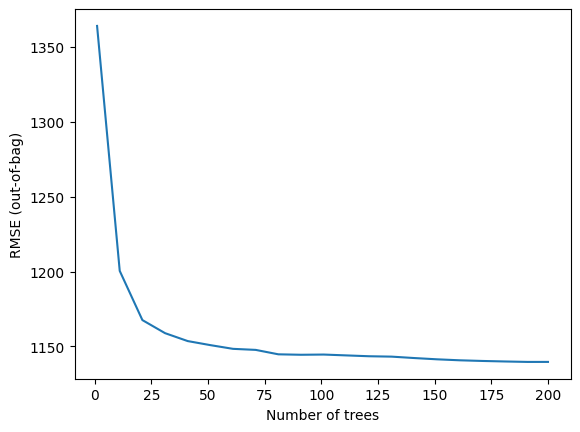

Feature Importances (SUM_SCORE):
"accommodates" (1; #1): 236538987921.5459
"property_type" (4; #9): 200010700372.1838
"bedrooms" (1; #3): 98055230671.8714
"neighbourhood_cleansed" (4; #6): 82325265766.9787
"baths" (1; #2): 66152732109.2933
"beds" (1; #4): 63956287110.6041
"maximum_nights_avg_ntm" (1; #5): 36097359206.1779
"number_of_reviews" (1; #7): 34203850835.1380
"number_of_reviews_ltm" (1; #8): 26659781684.1176
"review_scores_accuracy" (1; #10): 23956957393.1489
"review_scores_cleanliness" (1; #12): 20573380960.6221
"review_scores_checkin" (1; #11): 17586835440.5771
"review_scores_rating" (1; #15): 15025978807.5680
"review_scores_communication" (1; #13): 12682567952.4902
"review_scores_location" (1; #14): 12474005168.5986
"review_scores_value" (1; #16): 12070555686.5758
"reviews_per_month" (1; #17): 10759209950.8379
"room_type" (4; #18): 2652232714.4954


In [25]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()


# Make an inspector for the model
inspector = rf.make_inspector()

# Get feature importances
feature_importances = inspector.variable_importances()

# Display the "SUM_SCORE" importances
if "SUM_SCORE" in feature_importances:
    sum_scores = feature_importances["SUM_SCORE"]
    print("Feature Importances (SUM_SCORE):")
    for importance in sum_scores:
        print(f"{importance[0]}: {importance[1]:.4f}")
else:
    print("SUM_SCORE importances are not available.")


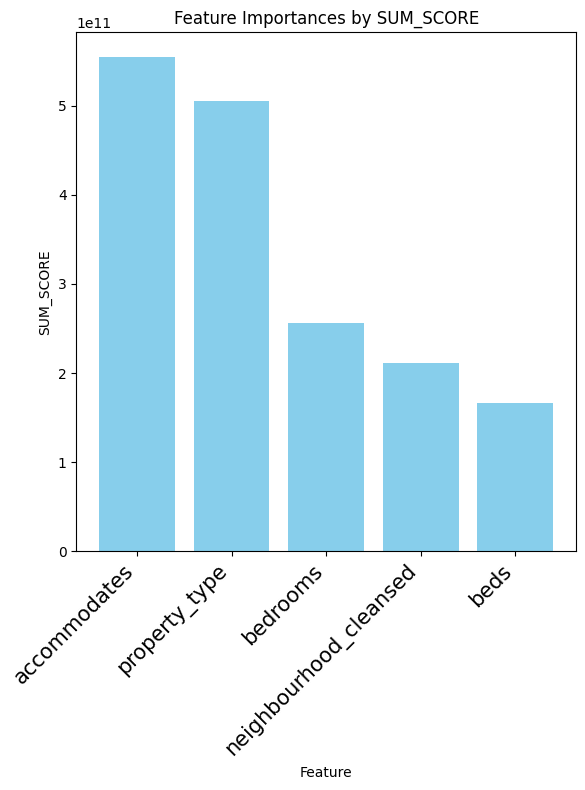

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert SUM_SCORE data to a DataFrame
sum_score_data = [
    ("accommodates", 554760377260.4235),
    ("property_type", 504981967422.18585),
    ("bedrooms", 255649891752.37616),
    ("neighbourhood_cleansed", 211588261430.85687),
    ("beds", 166318346297.08942),
]
sum_score_df = pd.DataFrame(sum_score_data, columns=["Feature", "Sum_Score"])

# Plot a vertical bar graph
plt.figure(figsize=(6, 8))
plt.bar(sum_score_df["Feature"], sum_score_df["Sum_Score"], color="skyblue")
plt.title("Feature Importances by SUM_SCORE")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.ylabel("SUM_SCORE")
#plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming `valid_ds` is the validation dataset and `rf` is your trained model

# Extract true labels from the validation dataset
y_true = []
for batch in valid_ds:
    _, labels = batch  # Assuming (features, labels) format
    y_true.extend(labels.numpy())  # Convert Tensor to NumPy and extend list

y_true = np.array(y_true)  # Convert list to NumPy array

# Generate predictions on the validation set
val_predictions = rf.predict(valid_ds)  # Convert to numpy and flatten

# Calculate R^2
r2 = r2_score(y_true, val_predictions)
print(f"R^2 Score: {r2:.4f}")

# Calculate MAE
mae = mean_absolute_error(y_true, val_predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, val_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Calculate MAPE
mape = np.mean(np.abs((y_true - val_predictions) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate Adjusted R^2
n = len(y_true)  # Number of data points
p = X.shape[1]   # Number of predictors/features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R^2: {adj_r2:.4f}")


2/2 [==============================] - 0s 5ms/step
R^2 Score: 0.2682
Mean Absolute Error (MAE): 916.1354
Root Mean Squared Error (RMSE): 1121.3754
Mean Absolute Percentage Error (MAPE): inf
Adjusted R^2: 0.2600


2024-11-27 23:06:50.112076: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/var/folders/gp/r9106f0d7cv0pg55j8gs_g7h0000gn/T/ipykernel_65450/1817607774.py:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - val_predictions) / y_true)) * 100


In [28]:
results_df = pd.read_csv('results.csv')

rf_res = pd.DataFrame({
    "Model": 'RF',
    "RMSE": [rmse],
    "MAE": [mae],
    "R²": [r2],
    "R² Adjusted": [adj_r2]
})
results_df = pd.concat([results_df, rf_res], ignore_index=True)
print(results_df)


     Model         RMSE         MAE        R²  R² Adjusted
0       LR  1163.750197  943.460734  0.235424     0.213335
1  XGBoost  1120.825188  911.963707  0.290663     0.270170
2      FNN  1119.944214  908.889038  0.291608     0.163153
3       RF  1121.375410  916.135361  0.268202     0.259972


In [29]:
results_df.to_csv('results.csv', index=False)

In [49]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
    print(name, value) 
    print(f"{name}: {value:.4f}")


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mse: 1257482.7500
loss 0.0
loss: 0.0000
mse 1257482.75
mse: 1257482.7500


In [15]:
import math
mse = evaluation['mse']
print("RMSE: ", math.sqrt(mse)) 


RMSE:  1121.3753831790673


## Variable  importances

In [30]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [31]:
inspector.variable_importances()["INV_MEAN_MIN_DEPTH"]

[("property_type" (4; #10), 0.385567072557072),
 ("accommodates" (1; #1), 0.36924951672840456),
 ("bedrooms" (1; #3), 0.15689743026073738),
 ("beds" (1; #4), 0.13296516997817762),
 ("neighbourhood_cleansed" (4; #7), 0.1282799538002263),
 ("bathrooms" (1; #2), 0.12748263518128128),
 ("host_is_superhost" (1; #5), 0.10234837414837711),
 ("maximum_nights_avg_ntm" (1; #6), 0.10219470331987418),
 ("number_of_reviews" (1; #8), 0.10162099733466802),
 ("review_scores_cleanliness" (1; #13), 0.10018398517071975),
 ("review_scores_rating" (1; #16), 0.10006504399684571),
 ("number_of_reviews_ltm" (1; #9), 0.09875754363308424),
 ("review_scores_accuracy" (1; #11), 0.09871424171611112),
 ("review_scores_checkin" (1; #12), 0.09569687170303086),
 ("review_scores_value" (1; #17), 0.09557603611113946),
 ("review_scores_communication" (1; #14), 0.09453456475224611),
 ("review_scores_location" (1; #15), 0.09314110724823055),
 ("reviews_per_month" (1; #18), 0.09201603296428074),
 ("room_type" (4; #19), 0.09

# Train from whole training data

In [32]:
train_all_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data, label=label, task = tfdf.keras.Task.REGRESSION)

In [33]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])
rf.fit(x=train_all_ds)


Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /var/folders/gp/r9106f0d7cv0pg55j8gs_g7h0000gn/T/tmpse6m8ghv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.160419. Found 5352 examples.
Training model...


I0000 00:00:1732098596.904131  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098596.904140  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098596.904144  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098596.904200  564816 kernel.cc:401] Number of batches: 6
I0000 00:00:1732098596.904204  564816 kernel.cc:402] Number of examples: 5352
I0000 00:00:1732098596.905191  564816 data_spec_inference.cc:354] 22 item(s) have been pruned (i.e. they are considered out of dictionary) for the column property_type (24 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098596.905204  564816 data_spec_inference.cc:354] 1 item(s) have be

Model trained in 0:00:03.326938
Compiling model...


I0000 00:00:1732098600.163944  564816 decision_forest.cc:761] Model loaded with 300 root(s), 370408 node(s), and 19 input feature(s).
2024-11-20 02:30:00.163978: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [34]:
testing = pd.read_csv("data/test.csv")
testing = clean(testing)

testing = testing[['id', 'host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type',
             
            'maximum_nights_avg_ntm',  'number_of_reviews',   
            'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'reviews_per_month', 'bedrooms', 'beds', 'bathrooms', 'accommodates']]
ids = testing.pop('id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
     testing,
     task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'id': ids,
                       'monthly_revenue': preds.squeeze()})
output.head()


2/2 [==============================] - 0s 26ms/step


,id,monthly_revenue
0,4465400,4281.810547
1,608629349064811166,1124.609619
2,981894508939312892,1952.244751
3,52014961,1790.515747
4,836285112356489303,1608.561279


In [35]:
output.to_csv('data/predicted.csv', index = False)

# XG

In [36]:
xg = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)
xg.compile(metrics=["mse"])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /var/folders/gp/r9106f0d7cv0pg55j8gs_g7h0000gn/T/tmp6ihcde06 as temporary training directory


2024-11-20 02:30:00.697270: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-11-20 02:30:00.697282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-11-20 02:30:00.697285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [37]:
xg.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:00.159926. Found 4272 examples.
Training model...


I0000 00:00:1732098600.868203  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098600.868213  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098600.868217  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098600.868280  564816 kernel.cc:401] Number of batches: 5
I0000 00:00:1732098600.868284  564816 kernel.cc:402] Number of examples: 4272
I0000 00:00:1732098600.869085  564816 data_spec_inference.cc:354] 19 item(s) have been pruned (i.e. they are considered out of dictionary) for the column property_type (23 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098600.869097  564816 data_spec_inference.cc:354] 1 item(s) have be

Model trained in 0:00:00.578055
Compiling model...


I0000 00:00:1732098601.432819  565275 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1145.92
2024-11-20 02:30:01.432841: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2024-11-20 02:30:01.435270: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2024-11-20 02:30:01.435759: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:1145.918335 valid-rmse:1145.918335
I0000 00:00:1732098601.436307  565275 kernel.cc:926] Export model in log directory: /var/folders/gp/r9106f0d7cv0pg55j8gs_g7h0000gn/T/tmp6ihcde06 with prefix 8f2400395ef044a6
I0000 00:00:1732098601.437180  565275 kernel.cc:944] Save model in resources
I0000 

Model compiled.


In [38]:
evaluation = xg.evaluate(valid_ds)
print(evaluation)

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 1255208.0000
[0.0, 1255208.0]


# Combining 2 models

In [39]:


xg.fit(valid_ds)
rf.fit(valid_ds)

predsRF = rf.predict(valid_ds)
predsXG = xg.predict(valid_ds)



Reading training dataset...
Training dataset read in 0:00:00.011570. Found 1080 examples.
Training model...
Model trained in 0:00:00.029505
Compiling model...


I0000 00:00:1732098601.667332  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098601.667347  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098601.667354  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098601.667417  564816 kernel.cc:401] Number of batches: 7
I0000 00:00:1732098601.667421  564816 kernel.cc:402] Number of examples: 1080
I0000 00:00:1732098601.667649  564816 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column neighbourhood_cleansed (22 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098601.667661  564816 data_spec_inference.cc:354] 19 item(s

Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.008096. Found 1080 examples.
Training model...


I0000 00:00:1732098601.753127  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098601.753139  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098601.753144  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098601.753208  564816 kernel.cc:401] Number of batches: 8
I0000 00:00:1732098601.753213  564816 kernel.cc:402] Number of examples: 1080
I0000 00:00:1732098601.753452  564816 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column neighbourhood_cleansed (22 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098601.753470  564816 data_spec_inference.cc:354] 19 item(s

Model trained in 0:00:00.675200
Compiling model...
Model compiled.
2/2 [==============================] - 0s 6ms/step


I0000 00:00:1732098602.410079  564816 decision_forest.cc:761] Model loaded with 300 root(s), 99028 node(s), and 19 input feature(s).
2024-11-20 02:30:02.410109: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


2/2 [==============================] - 0s 2ms/step


In [40]:
best_mse = float('inf')
best_weights = None

for w_rf in np.arange(0, 1.1, 0.1):  # Try weights from 0 to 1 in steps of 0.1
    w_xg = 1 - w_rf
    combined_preds = w_rf * predsRF + w_xg * predsXG
    mse = mean_squared_error(validation_ds_pd['monthly_revenue'], combined_preds)
    if mse < best_mse:
        best_mse = mse
        best_weights = (w_rf, w_xg)

mse = mean_squared_error(validation_ds_pd['monthly_revenue'], predsRF)

print("Best weights:", best_weights)
print("Best MSE:", best_mse)

Best weights: (np.float64(1.0), np.float64(0.0))
Best MSE: 399572.9700114067


## Train both on full

In [41]:
rf.fit(train_all_ds)
xg.fit(train_all_ds)

Reading training dataset...
Training dataset read in 0:00:00.072248. Found 5352 examples.
Training model...


I0000 00:00:1732098602.732664  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098602.732674  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098602.732679  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098602.732747  564816 kernel.cc:401] Number of batches: 14
I0000 00:00:1732098602.732752  564816 kernel.cc:402] Number of examples: 5352
I0000 00:00:1732098602.733784  564816 data_spec_inference.cc:354] 22 item(s) have been pruned (i.e. they are considered out of dictionary) for the column property_type (24 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098602.733797  564816 data_spec_inference.cc:354] 1 item(s) have b

Model trained in 0:00:03.136121
Compiling model...
Model compiled.
Reading training dataset...


I0000 00:00:1732098605.802594  564816 decision_forest.cc:761] Model loaded with 300 root(s), 370408 node(s), and 19 input feature(s).
I0000 00:00:1732098605.802624  564816 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-11-20 02:30:05.802633: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Training dataset read in 0:00:00.030577. Found 5352 examples.
Training model...


I0000 00:00:1732098606.014842  564816 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732098606.014854  564816 kernel.cc:783] Collect training examples
I0000 00:00:1732098606.014859  564816 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732098606.014924  564816 kernel.cc:401] Number of batches: 13
I0000 00:00:1732098606.014928  564816 kernel.cc:402] Number of examples: 5352
I0000 00:00:1732098606.016132  564816 data_spec_inference.cc:354] 22 item(s) have been pruned (i.e. they are considered out of dictionary) for the column property_type (24 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1732098606.016151  564816 data_spec_inference.cc:354] 1 item(s) have b

InvalidArgumentError: {{function_node __wrapped__SimpleMLCheckStatus_device_/job:localhost/replica:0/task:0/device:CPU:0}} Condition bitmap does not contain enough elements [Op:SimpleMLCheckStatus] name: 